<a href="https://colab.research.google.com/github/Anita-P-B/Food-Classification-Project/blob/main/Food_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Food Classification Project

**Description:** 
Image classification project using "Food-101", a dataset of labelled images from the source:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

**Objection:**
Build and train a classification model that can classify food images into one of the 101 food classes provided in the dataset Using deep learning models from TensorFlow library.


## Import neccesary libraries and tools

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers

from sklearn.metrics import classification_report


## Writing helper functions

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


In [ ]:
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Import and preprocesss the data

In [ ]:
# List all avaliable datasets
datasets_list=tfds.list_builders()
print("food101" in datasets_list)

# Load in the food101 dataset
(train_data,test_data), ts_info=tfds.load("food101",
                                          split=["train","validation"],
                                          shuffle_files=True,
                                          as_supervised=True, # include labels as well
                                          with_info=True) # going to download the metadata as well, into ts_info variabel

                                          # Features of food101 from TFDS
ts_info.features

True


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteP9GBPF/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteP9GBPF/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names=ts_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the food101 data from TensorFlow Datasets

In [ ]:
# Take one sample of training data
train_one_sample=train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output intp about the data sample
for image,label in train_one_sample:
  print(f"Image_shape: {image.shape}, image_datatype: {image.dtype},class from food101: {label}, class name:{class_names[label.numpy()]}")

Image_shape: (512, 384, 3), image_datatype: <dtype: 'uint8'>,class from food101: 19, class name:chicken_quesadilla


(-0.5, 383.5, 511.5, -0.5)

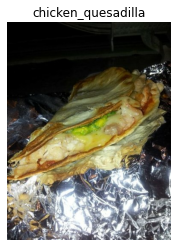

In [ ]:
# Print image tensor from TFDS food101
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [ ]:
# Print the min and max values of the image
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Data preprocessing
Define the following parameters:

1. Rescale values to 0-1 (Since we going to use Efficientnet this step is not required).
2. Change dtype to 'float32'.
3. Change images shapes to be (224,224).
4. One-Hot encode the labels.
4. Put data into batches, when all the tensor in the batch are in the same size.

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image,label,img_size=224):
  '''
  Converts image dtype to 'float32' and reshapes the image shape to
  (imG_shape,img_shape,color_channels).
  '''
  image=tf.image.resize(image,size=[img_size,img_size])
  return tf.cast(image, tf.float32), label

In [ ]:
# preprocess a single sample and check the output
pre_image=preprocess_img(image, label)[0]
pre_image.shape, pre_image.dtype

(TensorShape([224, 224, 3]), tf.float32)

### Batch and prepare datasets


In [ ]:
# Map preprocessing function and paralelize it 
train_data=train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train data, turn it into batches and prefetch the data (make it load faster)
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function for the test data 
test_data=test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

## Build and train models

### Helper functions and preparations for training models

In [ ]:
# Create a ModelCheckpoint callback
checkpoint_path="model_checkpoints/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,verbose=1,save_weights_only=True,
                                                    monitor="val_acc",save_best_only=True)

# Setup mixed prexition training
mixed_precision.set_global_policy("mixed_float16") # set global data policy for mixrd precision


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


### Build feature extraction model

In [ ]:
# Create base model
input_shape=(224,224,3)
base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create functional model
inputs=layers.Input(shape=input_shape,name="input_layer")
# Note EfficientnetBx have rescaling build-in. Other wise a rescaling is required
# x=preprocessing.Rescaling(1/255.)(x)
x=base_model(inputs, training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs=layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model=tf.keras.Model(inputs,outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Checking layers dtyep policies (are we using mixed precision?)

for layer in model.layers:
  print( layer.name, layer.trainable,f"Dtype policy is {layer.dtype_policy}", f"Dtype is {layer.dtype}")

  

input_layer True Dtype policy is <Policy "float32"> Dtype is float32
efficientnetb0 False Dtype policy is <Policy "mixed_float16"> Dtype is float32
global_average_pooling2d True Dtype policy is <Policy "mixed_float16"> Dtype is float32
dense True Dtype policy is <Policy "mixed_float16"> Dtype is float32
softmax_float32 True Dtype policy is <Policy "float32"> Dtype is float32


In [ ]:
# Chack the dtype policied of layers in the base model:
for layer in model.layers[1].layers[:10]:
  print( layer.name, layer.trainable,f"Dtype policy is {layer.dtype_policy}", f"Dtype is {layer.dtype}")


input_1 False Dtype policy is <Policy "float32"> Dtype is float32
rescaling False Dtype policy is <Policy "mixed_float16"> Dtype is float32
normalization False Dtype policy is <Policy "mixed_float16"> Dtype is float32
stem_conv_pad False Dtype policy is <Policy "mixed_float16"> Dtype is float32
stem_conv False Dtype policy is <Policy "mixed_float16"> Dtype is float32
stem_bn False Dtype policy is <Policy "mixed_float16"> Dtype is float32
stem_activation False Dtype policy is <Policy "mixed_float16"> Dtype is float32
block1a_dwconv False Dtype policy is <Policy "mixed_float16"> Dtype is float32
block1a_bn False Dtype policy is <Policy "mixed_float16"> Dtype is float32
block1a_activation False Dtype policy is <Policy "mixed_float16"> Dtype is float32


### Train the feature extraction mdoel

In [ ]:
# Fit the model
history_1=model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    batch_size=32,
                    callbacks=[model_checkpoint  ],
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8204 - accuracy: 0.5584WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 266s 104ms/step - loss: 1.8204 - accuracy: 0.5584 - val_loss: 1.2315 - val_accuracy: 0.6761
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2925 - accuracy: 0.6662WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 269s 113ms/step - loss: 1.2926 - accuracy: 0.6662 - val_loss: 1.1262 - val_accuracy: 0.6989
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1435 - accuracy: 0.7017WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 266s 112ms/step - loss: 1.1435 - accuracy: 0.7017 - val_loss: 1.0848 - val_accuracy: 0.7048


In [ ]:
# Check the validation accuracy for each epoch
history_1.history["val_accuracy"]

[0.676118791103363, 0.698851466178894, 0.7047920823097229]

### Fine tune the model

In [ ]:
# Clone model
model_2=tf.keras.models.clone_model(model)


In [ ]:

# Check model_2 summary
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Change all the parameters in the model to be trainable
model_2.trainbale=True

In [ ]:
# Check the trainable parameter in model_2 layers
for layer in model_2.layers:
  print(layer.name,layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
softmax_float32 True


In [ ]:
# Check the dtype policy in model_@ layers
for layer in model_2.layers:
  print(layer.name, layer.dtype_policy) 

input_layer <Policy "float32">
efficientnetb0 <Policy "mixed_float16">
global_average_pooling2d <Policy "mixed_float16">
dense <Policy "mixed_float16">
softmax_float32 <Policy "float32">


In [ ]:
# Setup an early stopping callback
early_stopping_callback=tf.keras.callbacks.EarlyStopping(verbose=1,patience=3)
model_2_checkpoint_path="model_checkpoints/model_2_cp.ckpt"
model_2_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=model_2_checkpoint_path,
                                                       save_best_only=True)

In [ ]:
# Compile model_@
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                 metrics=["accuracy"])

# Fit the model
history_2=model_2.fit(train_data,
                       epochs=6,
                       steps_per_epoch=len(train_data),
                       callbacks=[early_stopping_callback,model_2_checkpoint],
                       validation_data=test_data,
                       validation_steps=int(0.15*len(test_data)))

Epoch 1/6


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2368/2368 [==============================] - ETA: 0s - loss: 4.6152 - accuracy: 0.0082INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


2368/2368 [==============================] - 254s 103ms/step - loss: 4.6152 - accuracy: 0.0082 - val_loss: 4.6151 - val_accuracy: 0.0095
Epoch 2/6
2367/2368 [============================>.] - ETA: 0s - loss: 4.6152 - accuracy: 0.0092INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


2368/2368 [==============================] - 244s 102ms/step - loss: 4.6152 - accuracy: 0.0092 - val_loss: 4.6151 - val_accuracy: 0.0103
Epoch 3/6
2367/2368 [============================>.] - ETA: 0s - loss: 4.6152 - accuracy: 0.0087INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


2368/2368 [==============================] - 243s 102ms/step - loss: 4.6152 - accuracy: 0.0087 - val_loss: 4.6151 - val_accuracy: 0.0127
Epoch 4/6
2367/2368 [============================>.] - ETA: 0s - loss: 4.6152 - accuracy: 0.0089INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


2368/2368 [==============================] - 241s 101ms/step - loss: 4.6152 - accuracy: 0.0089 - val_loss: 4.6151 - val_accuracy: 0.0122
Epoch 5/6
2367/2368 [============================>.] - ETA: 0s - loss: 4.6152 - accuracy: 0.0093INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


2368/2368 [==============================] - 241s 101ms/step - loss: 4.6152 - accuracy: 0.0093 - val_loss: 4.6151 - val_accuracy: 0.0114
Epoch 6/6
2368/2368 [==============================] - ETA: 0s - loss: 4.6152 - accuracy: 0.0093INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_2_cp.ckpt/assets


2368/2368 [==============================] - 244s 102ms/step - loss: 4.6152 - accuracy: 0.0093 - val_loss: 4.6151 - val_accuracy: 0.0138


## Analyze the trained model

### Find the precision, recall and f1 scores for each class (all 101).

In [ ]:
# Make predictions on model_2
predictions=model_2.predict(test_data,verbose=1)


In [ ]:
# Convert the probability predictions to class names
pred_classes=predictions.argmax(axis=1)
len(pred_classes), type(pred_classes)

In [ ]:
# To get the test_data labels test_data_BatchDataSet need ot be unravelled
true_labels=[]
for images,labels in test_data.unbatch():
  true_labels.append(labels.numpy().argmax())
true_labels[:10]
len(true_labels)

In [ ]:
# Nake sure the predicted classes and the true labels are of the same lebgth
len(pred_classes), len(true_labels)

In [ ]:
# Insert classification report into dictionary
class_rep_dict=classification_report(y_true=true_labels,y_pred=pred_classes,output_dict=True)
# Create empty dictionary
class_f1_scores={}

#Lopp through classification report dictionary items 
for key, value in class_rep_dict.items():
  if key=='accuracy': # Stop when approach this line 
    break
  else:
    # Add class names and f1 scores to new dictionary
    class_f1_scores[class_names[int(key)]]=value['f1-score']

In [ ]:
# Insert the f1 scores into pandas DataFrane and sort the values
f1_scores=pd.DataFrame({"class_names": list(class_f1_scores.keys()), "f1_score": list(class_f1_scores.values())}).sort_values("f1_score",ascending=False)
f1_scores